#### Import libraries

In [152]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

#from xgboost import XGBClassifier

import shap


#### Read data

In [153]:
## Data source: https://github.com/IBM/telco-customer-churn-on-icp4d/tree/master/data

#path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
path_ibm = 'data/Telco-Customer-Churn.csv'

data_raw = pd.read_csv(path, sep=',')
data_ibm = pd.read_csv(path_ibm, sep=',')
data_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [154]:
## Total charges is a string, convert to numeric later

data_ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### Data dictionary

| Field               | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| customerID          | As is                                |
| gender              | Whether the customer is a male or a female                                 |
| SeniorCitizen       | Whether the customer is a senior citizen or not (1, 0)                    |
| Partner             | Whether the customer has a partner or not (Yes, No)                       |
| Dependents          | Whether the customer has dependents or not (Yes, No)                      |
| tenure              | Number of months the customer has stayed with the company                 |
| PhoneService        | Whether the customer has phone service or not (Yes, No)                   |
| MultipleLines       | Whether the customer has multiple lines or not (Yes, No, No phone service)|
| InternetService     | Customer’s internet service provider (DSL, Fiber optic, No)               |
| OnlineSecurity      | Whether the customer has online security or not (Yes, No, No internet service) |
| OnlineBackup        | Whether the customer has online backup or not (Yes, No, No internet service) |
| DeviceProtection    | Whether the customer has device protection or not (Yes, No, No internet service) |
| TechSupport         | Whether the customer has tech support or not (Yes, No, No internet service) |
| StreamingTV         | Whether the customer has streaming TV or not (Yes, No, No internet service) |
| StreamingMovies     | Whether the customer has streaming movies or not (Yes, No, No internet service) |
| Contract            | The contract term of the customer (Month-to-month, One year, Two year)    |
| PaperlessBilling    | Whether the customer has paperless billing or not (Yes, No)               |
| PaymentMethod       | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges      | The amount charged to the customer monthly                                |
| TotalCharges        | The total amount charged to the customer                                  |
| Churn (Target Variable) | Whether the customer churned or not (Yes or No)                       |

#### Quick inspection

In [155]:
data_ibm['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

#### Preliminary ETL

In [156]:
## Map response variable to binary for modelling

data_ibm['SeniorCitizen'] = data_ibm['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
data_ibm['SeniorCitizen'] = data_ibm['SeniorCitizen'].astype('category')

In [157]:
## Convert total charges to numeric

data_ibm['TotalCharges'] = pd.to_numeric(data_ibm['TotalCharges'], errors = 'coerce')
data_ibm.dropna(inplace = True)
#data_raw.info()

In [158]:
## Drop customer ID which can't be used in modelling

data = data_ibm.drop(['customerID'], axis = 1)

#### EDA

In [159]:
## Separate categorical and numerical columns for EDA and modelling

cat_col = data.select_dtypes(include=['object', 'category']).columns
cat_col = cat_col.drop('Churn')

num_col = data.select_dtypes(include=['int64', 'float64']).columns
print(cat_col.tolist()) 
print(num_col.tolist())

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['tenure', 'MonthlyCharges', 'TotalCharges']


/var/folders/ch/1t7jcm7n0ng98g472x2ynf7r0000gn/T/ipykernel_51418/607528536.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_count = data.groupby(feature)['Churn'].value_counts().unstack()


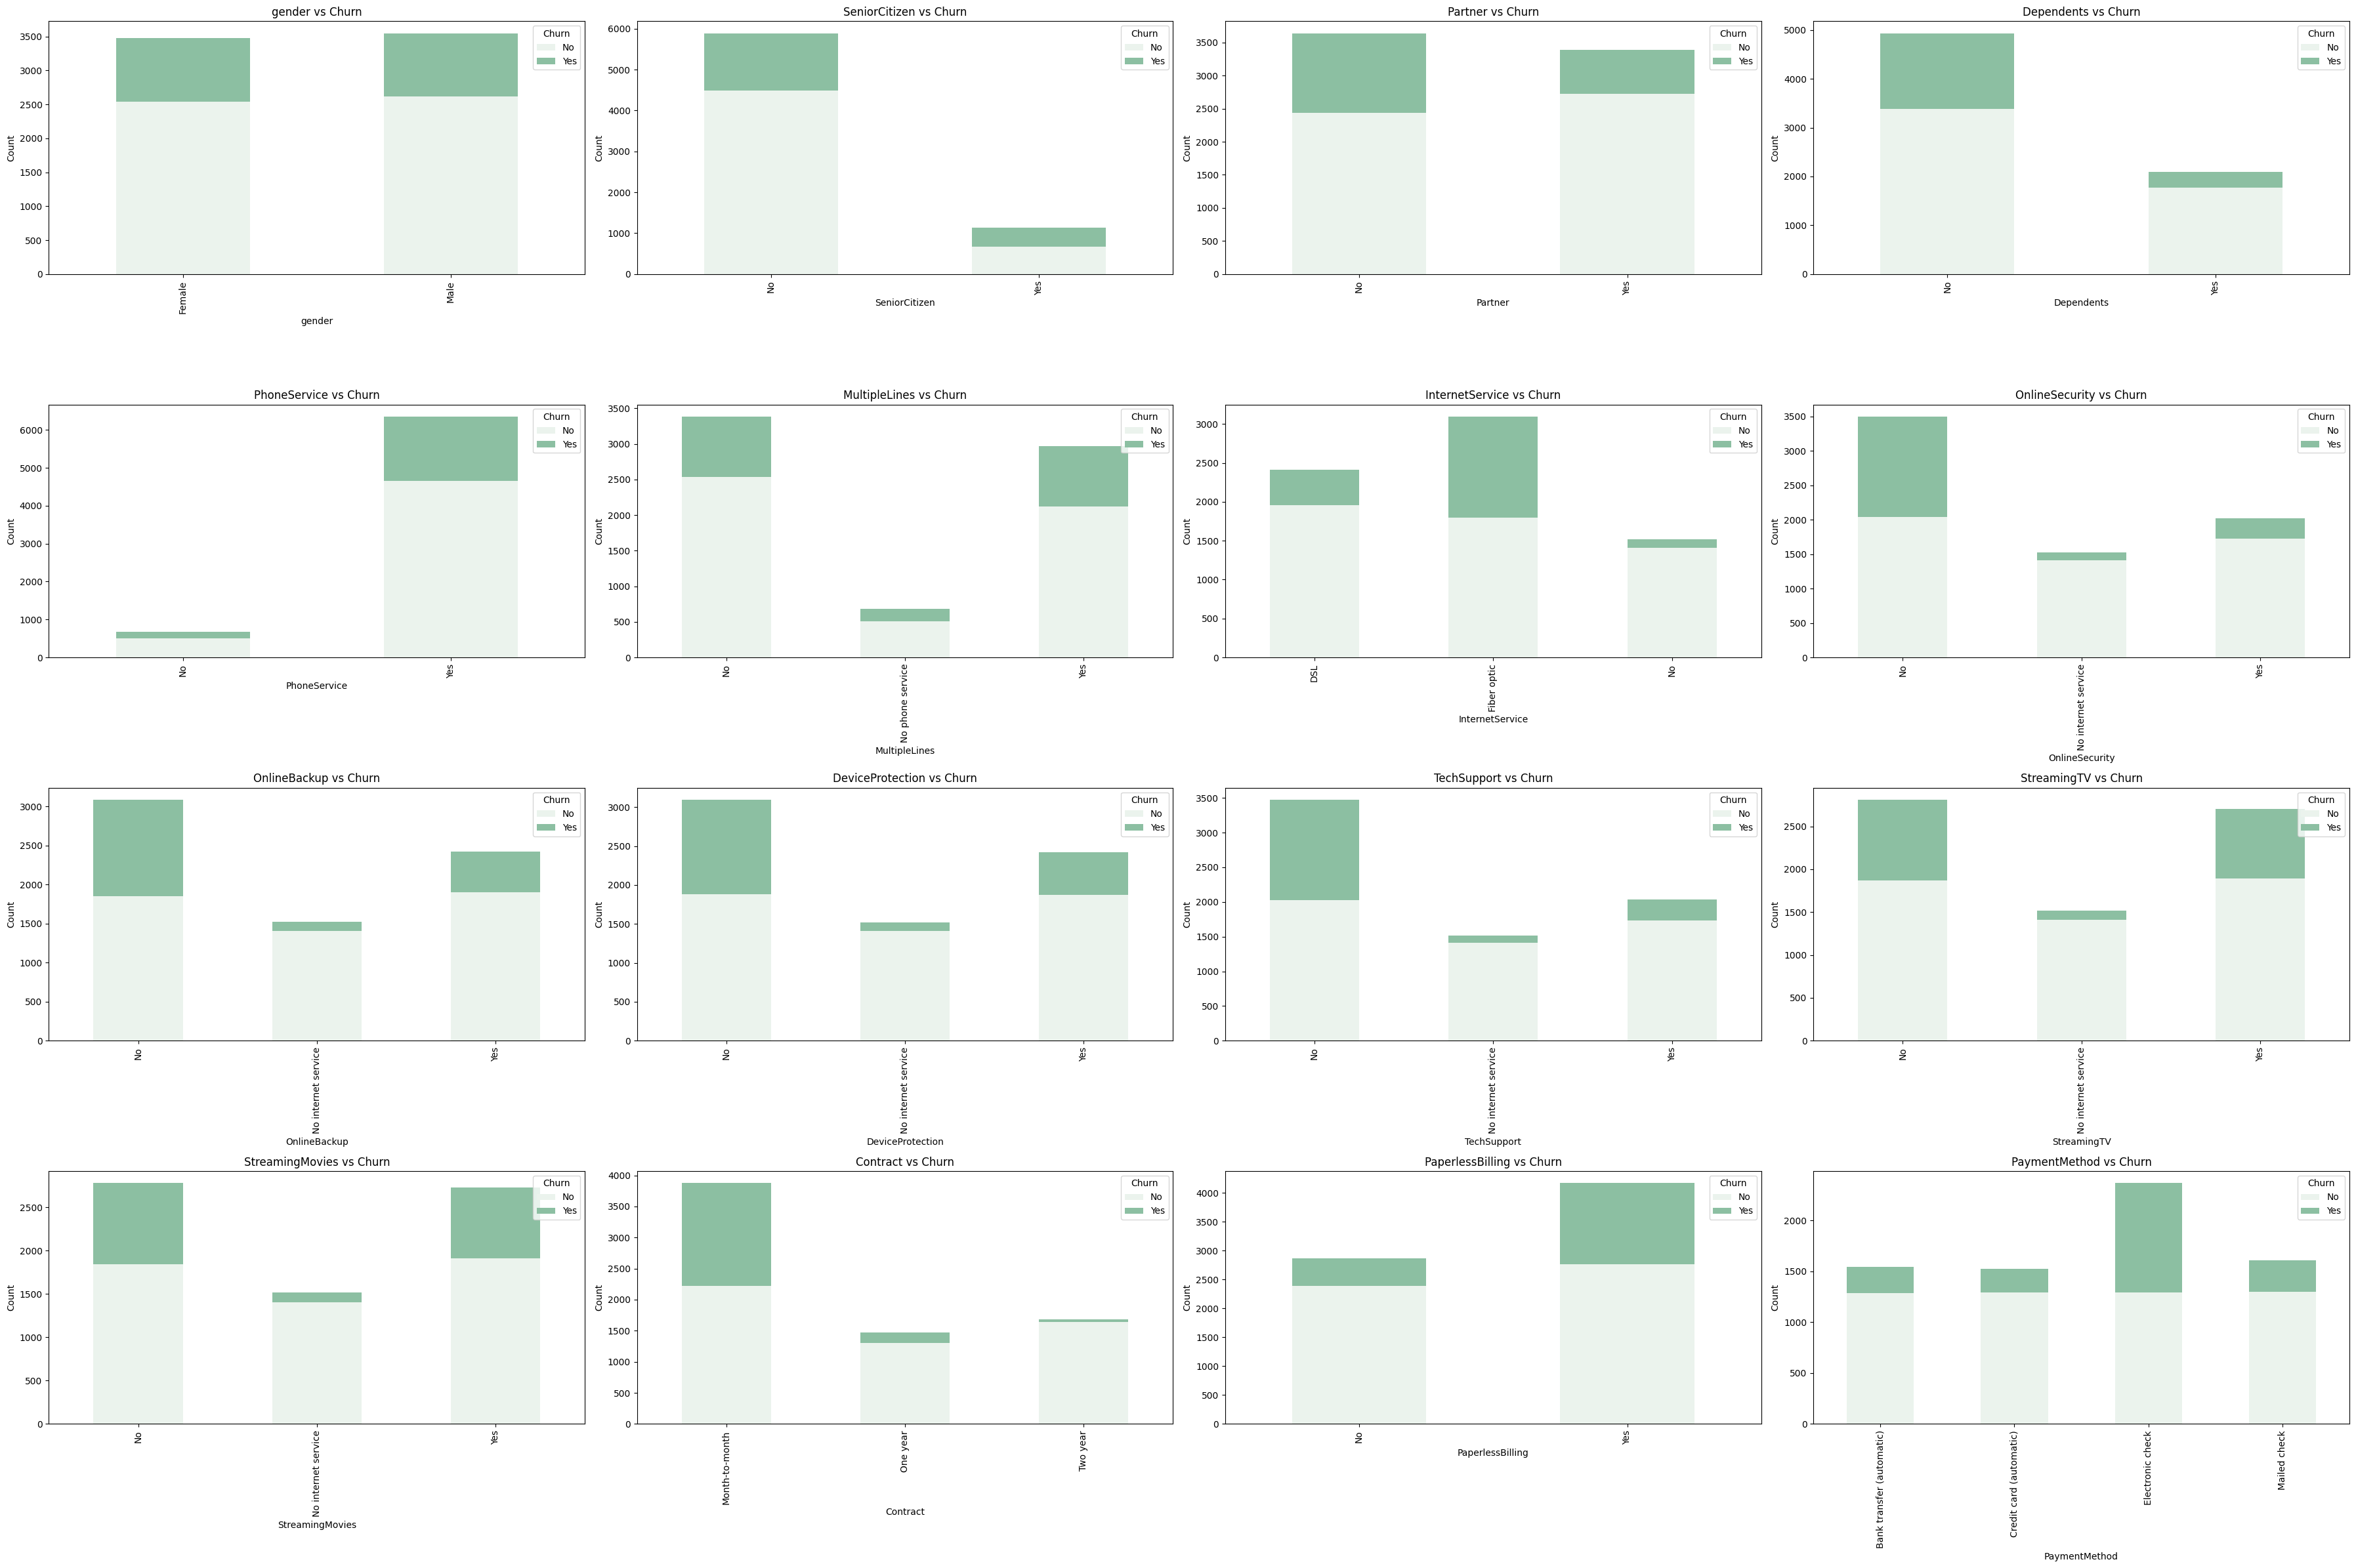

In [160]:
## Plot distribution of categoriacl variables against response variable by count

plt.figure(figsize = (36, 24))

sequential_palette = sns.light_palette("seagreen", as_cmap=True)

for i, feature in enumerate(cat_col, 1):
    plt.subplot(4, 4, i)
    churn_count = data.groupby(feature)['Churn'].value_counts().unstack()
    
    num_categories = churn_count.shape[1]  # Number of churn categories
    colors = [sequential_palette(i / num_categories) for i in range(num_categories)]
    
    churn_count.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)
    plt.title(f'{feature} vs Churn')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/ch/1t7jcm7n0ng98g472x2ynf7r0000gn/T/ipykernel_51418/697019422.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_percent = data.groupby(feature)['Churn'].value_counts(normalize = True).unstack() * 100


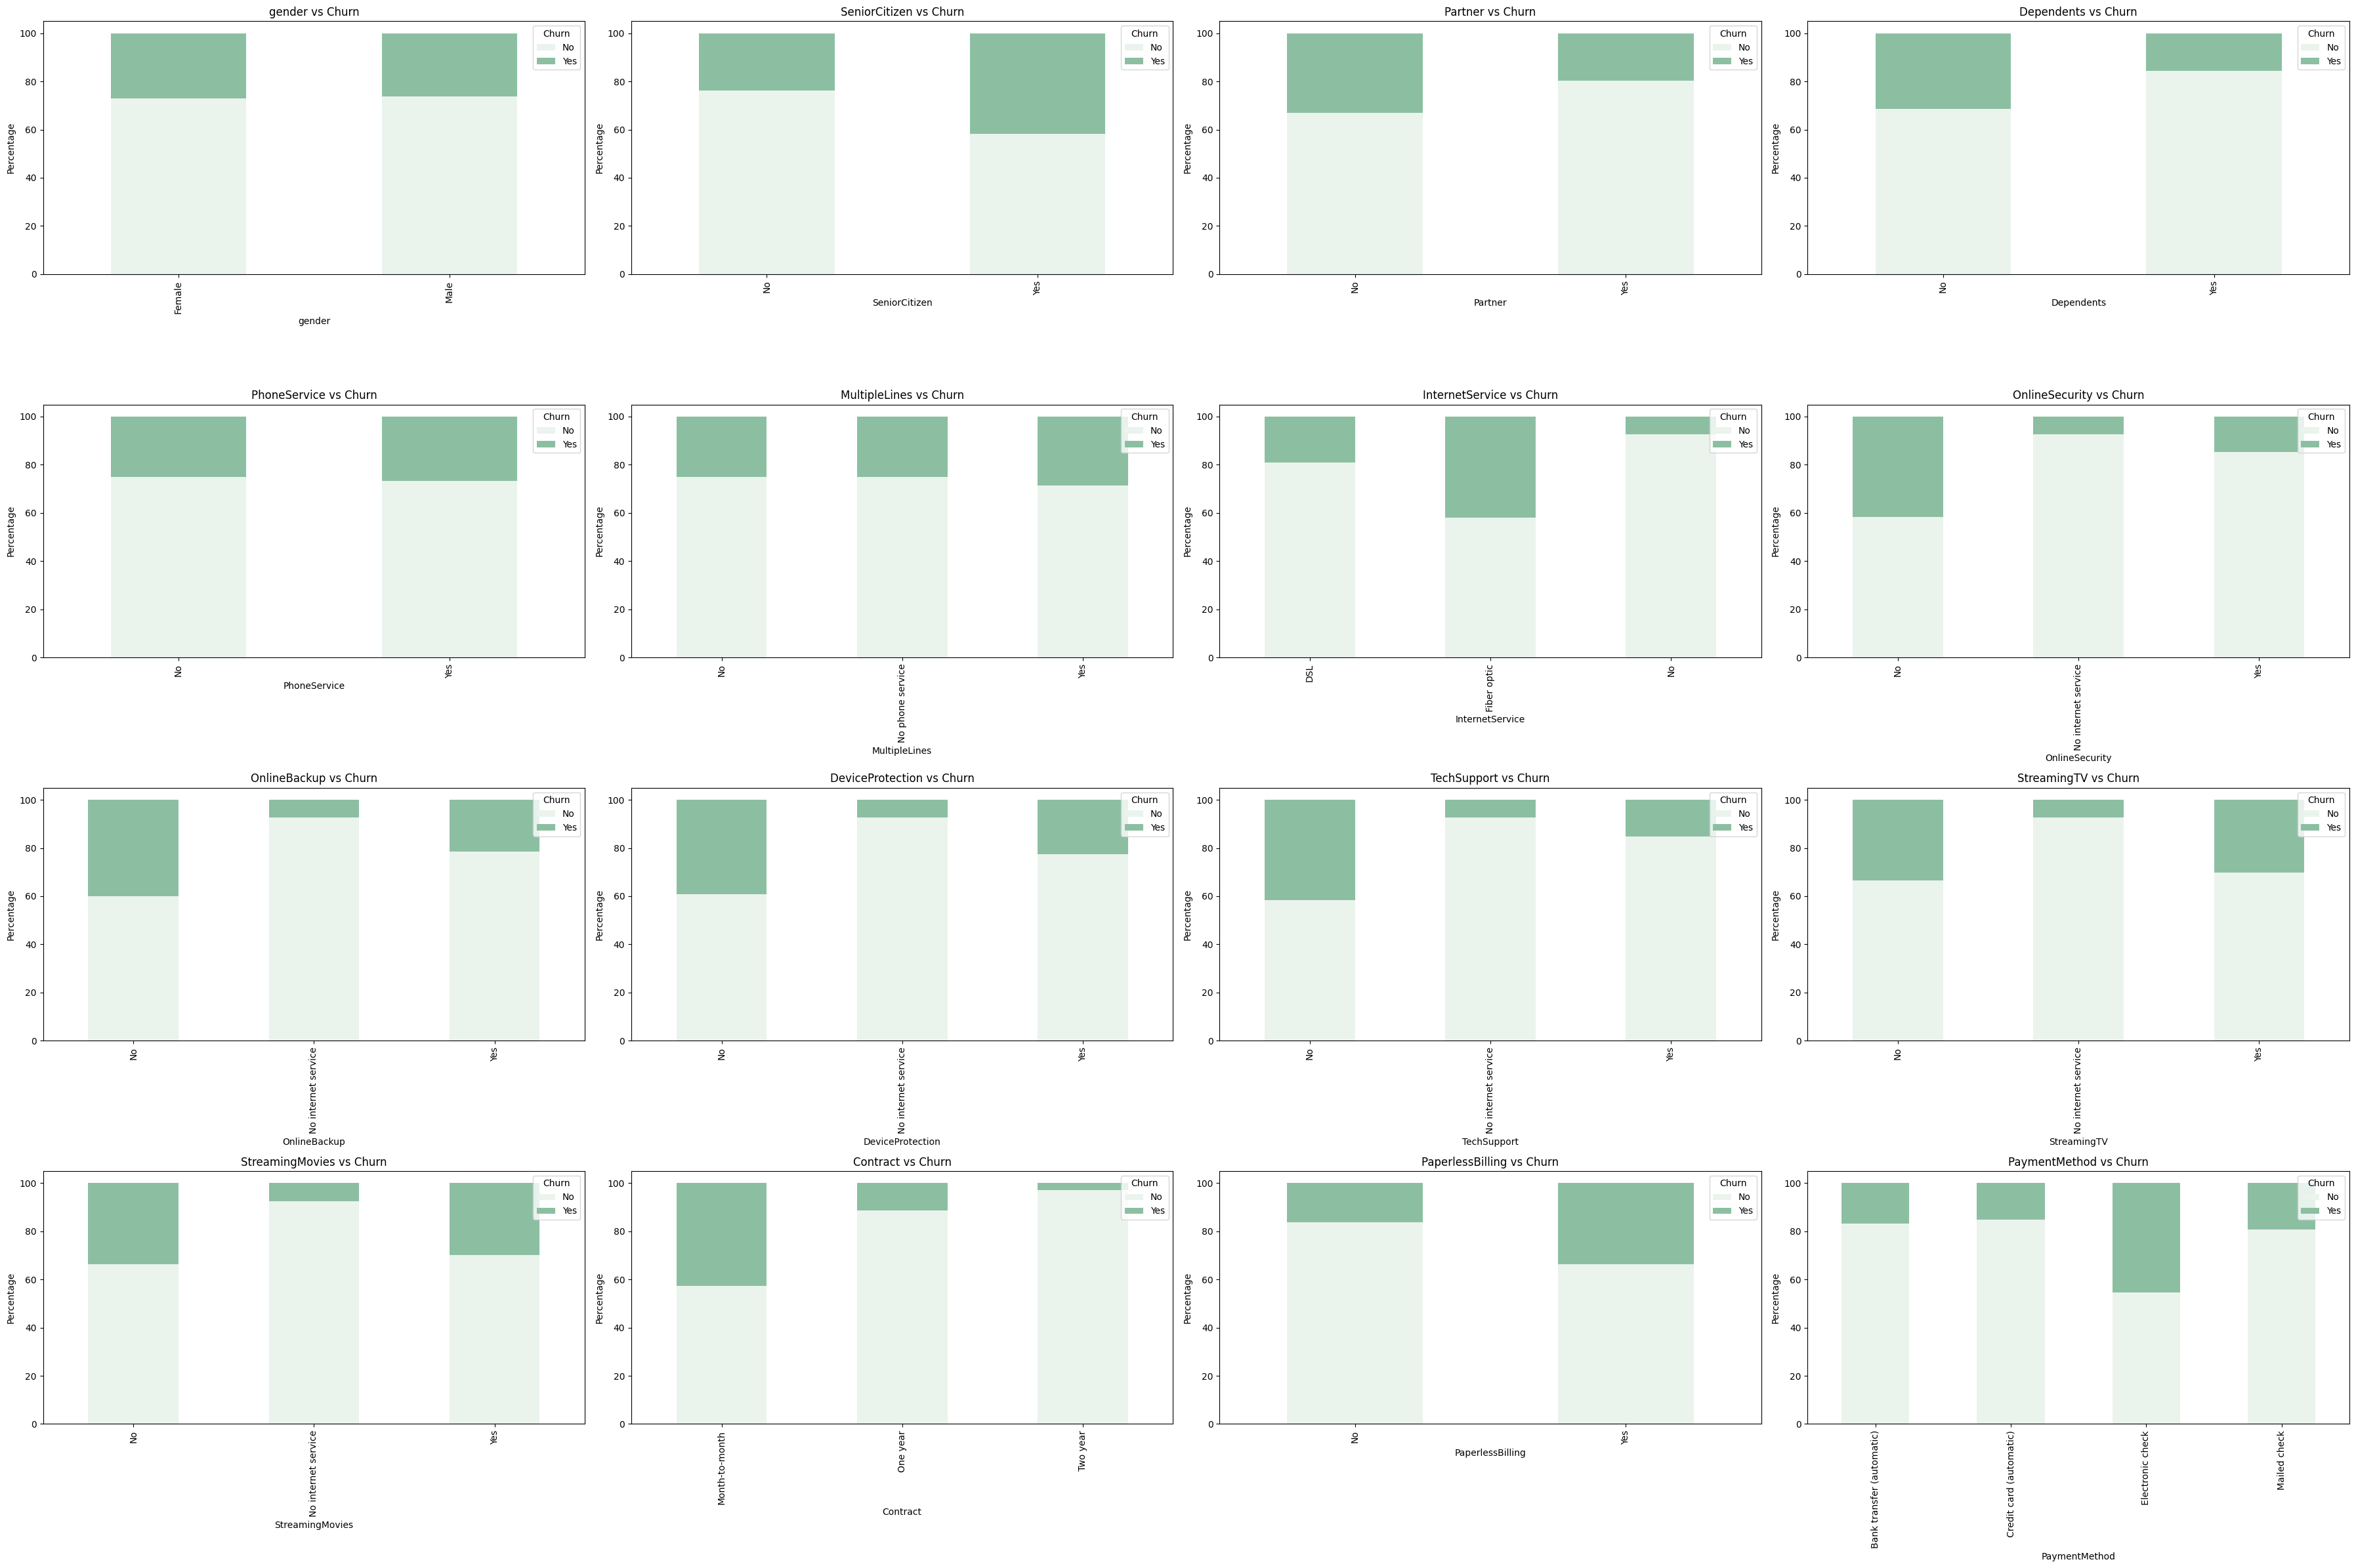

In [161]:
## Plot distribution of categoriacl variables against response variable by count, normalised for percentages

plt.figure(figsize=(36, 24))

sequential_palette = sns.light_palette("seagreen", as_cmap=True)

for i, feature in enumerate(cat_col, 1):
    plt.subplot(4, 4, i)
    # Calculate the percentage of churn
    churn_percent = data.groupby(feature)['Churn'].value_counts(normalize = True).unstack() * 100

    num_categories = len(churn_percent.columns)  # Number of churn categories
    colors = [sequential_palette(i / num_categories) for i in range(num_categories)]
    
    churn_percent.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)
    plt.title(f'{feature} vs Churn')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()

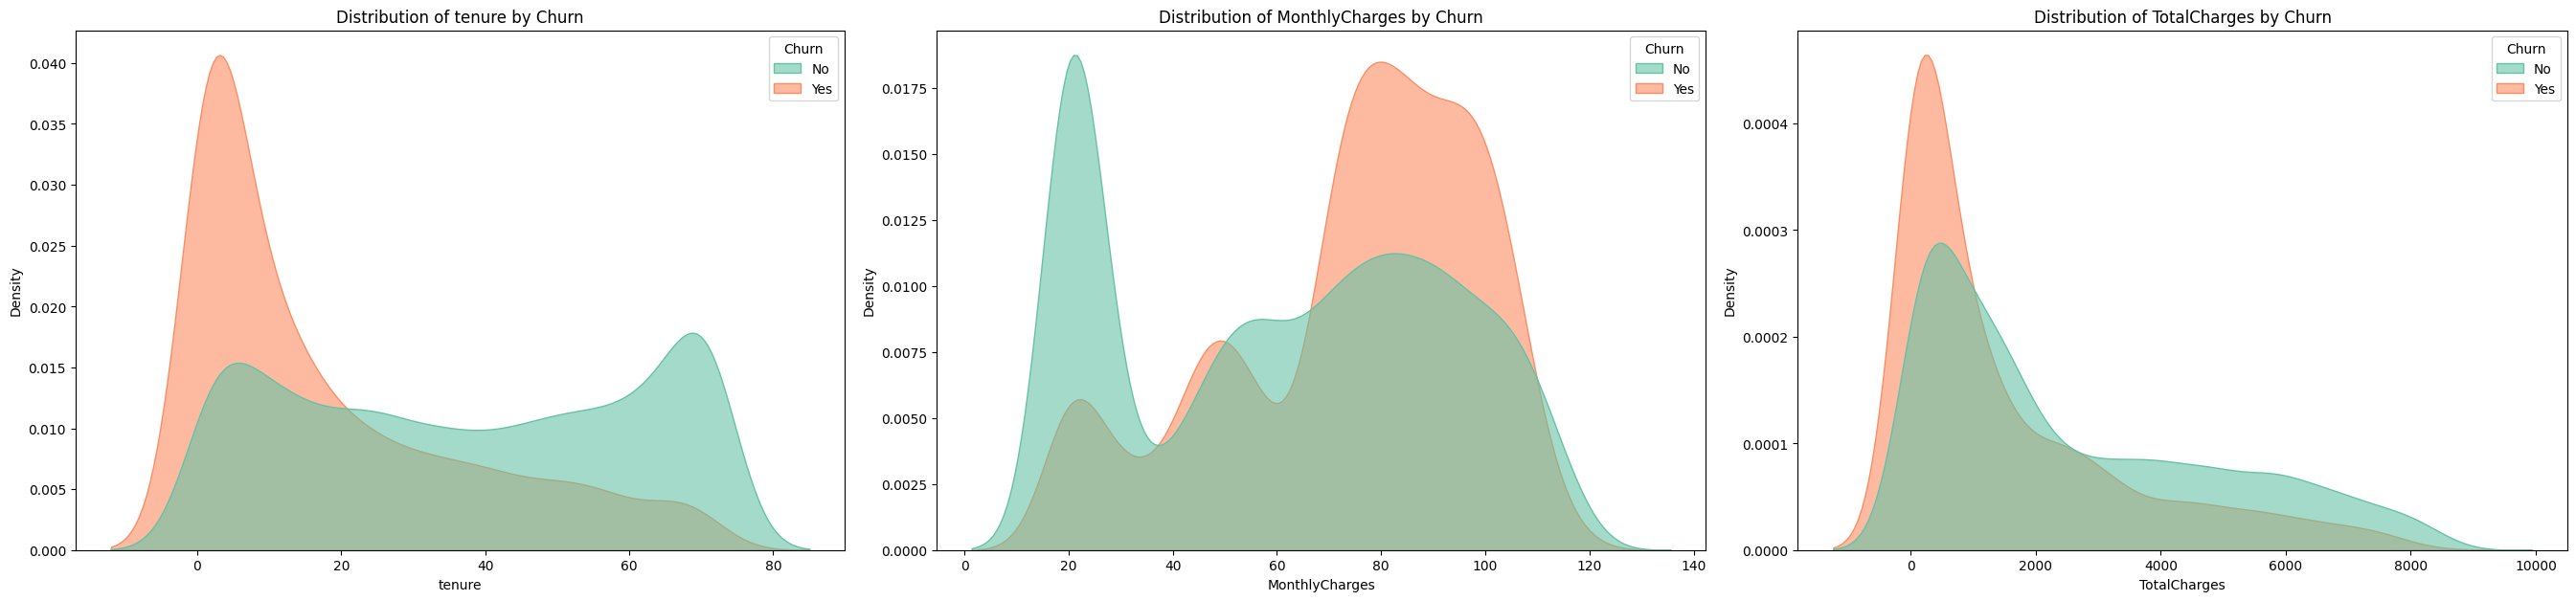

In [162]:
## Plot distribution of numerical variables against response variable by count

plt.figure(figsize = (36, 24))

for i, feature in enumerate(num_col, 1):
    plt.subplot(4, 4, i)
    
    # Plot the distribution for each churn category
    sns.kdeplot(
        data=data, 
        x=feature, 
        hue='Churn', 
        fill=True, 
        common_norm=False, 
        alpha=0.6,
        palette="Set2"
    )
    
    plt.title(f'Distribution of {feature} by Churn')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### Check correlation

- Certain features are naturally correlated, such as TotalCharges and Tenure, TotalCharges and MonthlyCharges, Tenure and Contract (i.e. locked in for a period of time), Partner and Dependents.

- Gender has no correlation with other features at face value.


In [163]:
## Print unique values of all categorical variables

unique_values = {col: data[col].unique().tolist() for col in cat_col}

# Print the unique values
for feature, values in unique_values.items():
    print(f"{feature}: {values}")

gender: ['Female', 'Male']
SeniorCitizen: ['No', 'Yes']
Partner: ['Yes', 'No']
Dependents: ['No', 'Yes']
PhoneService: ['No', 'Yes']
MultipleLines: ['No phone service', 'No', 'Yes']
InternetService: ['DSL', 'Fiber optic', 'No']
OnlineSecurity: ['No', 'Yes', 'No internet service']
OnlineBackup: ['Yes', 'No', 'No internet service']
DeviceProtection: ['No', 'Yes', 'No internet service']
TechSupport: ['No', 'Yes', 'No internet service']
StreamingTV: ['No', 'Yes', 'No internet service']
StreamingMovies: ['No', 'Yes', 'No internet service']
Contract: ['Month-to-month', 'One year', 'Two year']
PaperlessBilling: ['Yes', 'No']
PaymentMethod: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']


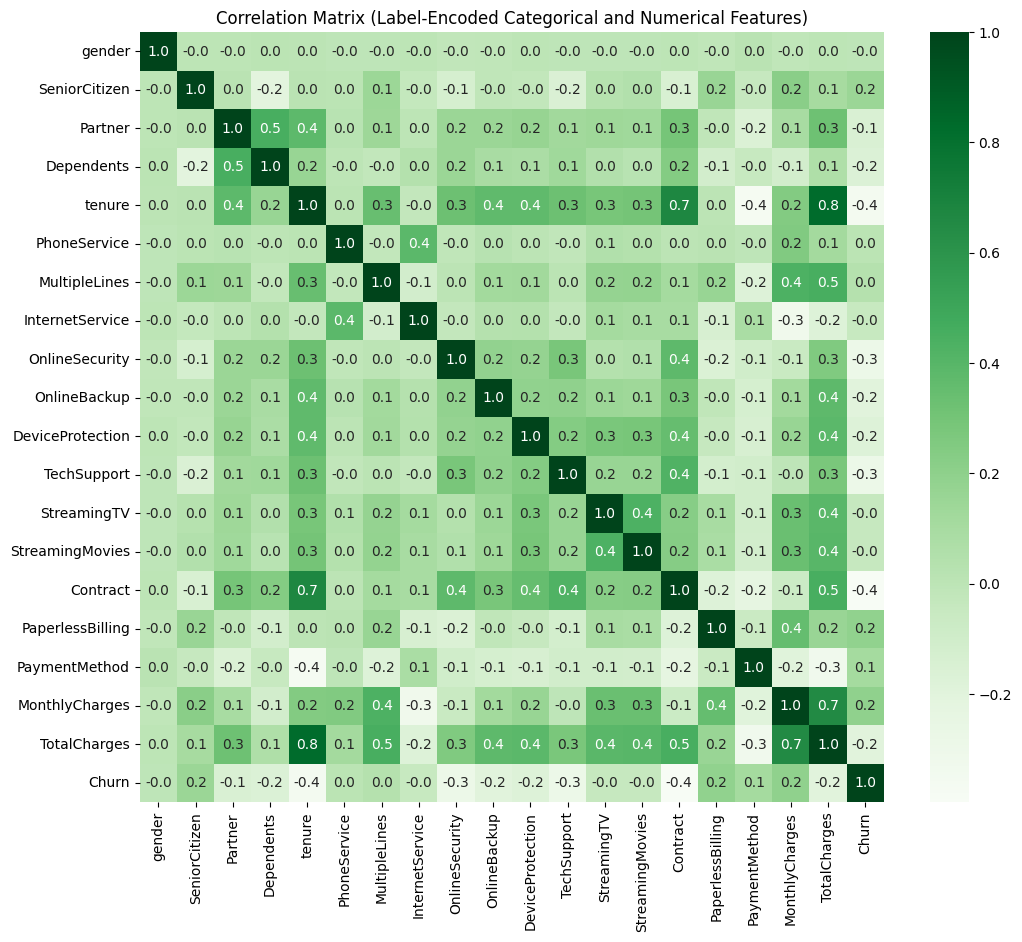

In [164]:
## Plot correlation heatmap, darker colour represents higher correlation

encoded_data = data.copy()

le = LabelEncoder()

categorical_features = encoded_data.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    encoded_data[col] = le.fit_transform(encoded_data[col])

correlation_matrix = encoded_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'Greens', fmt = ".1f", cbar = True)
plt.title("Correlation Matrix (Label-Encoded Categorical and Numerical Features)")
plt.show()

#### GLM

##### Define function

In [165]:
## Function for plotting confusion matrix

def plot_confusion_matrix(y_test, y_pred_class, labels = None):
    """
    Plots a confusion matrix as a heatmap.

    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)

    font_size = 8
    
    # Set default labels if not provided
    if labels is None:
        labels = ["No", "Yes"]  # Generic labels (can be customized)

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = labels, yticklabels = labels, annot_kws={"size": font_size})
    plt.title('Confusion Matrix', fontsize = font_size)
    plt.xlabel('Predicted Label', fontsize = font_size)
    plt.ylabel('True Label', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font_size)
    plt.show()

##### Prepare data

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   object  
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   object  
 3   Dependents        7032 non-null   object  
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   object  
 6   MultipleLines     7032 non-null   object  
 7   InternetService   7032 non-null   object  
 8   OnlineSecurity    7032 non-null   object  
 9   OnlineBackup      7032 non-null   object  
 10  DeviceProtection  7032 non-null   object  
 11  TechSupport       7032 non-null   object  
 12  StreamingTV       7032 non-null   object  
 13  StreamingMovies   7032 non-null   object  
 14  Contract          7032 non-null   object  
 15  PaperlessBilling  7032 non-null   object  
 16  PaymentMethod     7032 non-nu

In [167]:
## Separate features and response variable

X = data.drop('Churn', axis = 1)
y = data['Churn'].map({'No': 0, 'Yes': 1})

In [168]:
## Perform encoding to categorical variables

#numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_col),
        ('cat', categorical_transformer, cat_col)
    ]
)

# Apply preprocessing
X_encoded = preprocessor.fit_transform(X)

categorical_encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_col)
all_columns = list(num_col) + list(categorical_encoded_columns)
X_encoded = pd.DataFrame(X_encoded, columns = all_columns)

X_encoded

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,29.85,29.85,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,34.0,56.95,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,53.85,108.15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,45.0,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2.0,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,24.0,84.80,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
7028,72.0,103.20,7362.90,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
7029,11.0,29.60,346.45,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7030,4.0,74.40,306.60,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 44)

# Reset index for all datasets
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

# Step 4: Fit a Logistic Regression Model under GLM
X_train = sm.add_constant(X_train)

glm_model = sm.GLM(y_train, X_train, family = sm.families.Binomial())
glm_results = glm_model.fit()

print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2028.2
Date:                Sat, 28 Dec 2024   Deviance:                       4056.3
Time:                        15:26:49   Pearson chi2:                 5.66e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2793
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1534
           1       0.65      0.58      0.62       576

    accuracy                           0.80      2110
   macro avg       0.75      0.73      0.74      2110
weighted avg       0.80      0.80      0.80      2110

ROC AUC Score: 0.8446073038896131


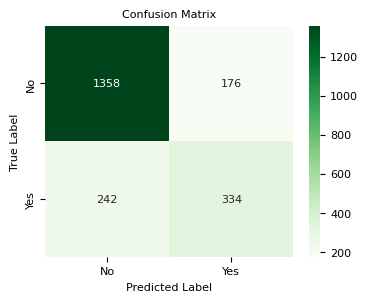

In [170]:
X_test = sm.add_constant(X_test)  # Ensure constant term for test data
y_pred = glm_results.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred_class, labels = None)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1534
           1       1.00      0.03      0.06       576

    accuracy                           0.74      2110
   macro avg       0.87      0.52      0.45      2110
weighted avg       0.81      0.74      0.63      2110

ROC AUC Score: 0.8446073038896131


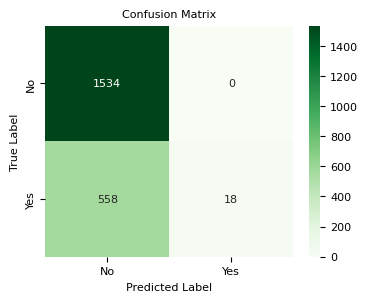

In [171]:
## Try changing threshold of 0.5 to get a better Precision
## This gives a perfect Precision score which was somewhat reflected in the AUC

X_test = sm.add_constant(X_test)  # Ensure constant term for test data
y_pred = glm_results.predict(X_test)
y_pred_class = (y_pred >= 0.8).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred_class, labels = None)

##### Add interaction terms

In [172]:
## Add interaction terms per correlation heatmap, for tenure x contract
## This is to demo GLM fit only

#interaction_pairs = [('tenure', 'InternetService_Fiber optic'), ('MonthlyCharges', 'PaymentMethod_Electronic check')]  # Replace with actual feature names
X_train_glm = X_train.copy()
X_test_glm = X_test.copy()

interaction_pairs = [('tenure', 'Contract_Two year'), 
                     ('tenure', 'Contract_One year'),
                    # ('tenure', 'Contract_Month-to-month')
]

# Add interaction terms to training and testing sets
for pair in interaction_pairs:
    interaction_name = f"{pair[0]}_x_{pair[1]}"
    X_train_glm[interaction_name] = X_train_glm[pair[0]] * X_train_glm[pair[1]]
    X_test_glm[interaction_name] = X_test_glm[pair[0]] * X_test_glm[pair[1]]

In [173]:
#X_train_glm.info()

In [174]:
glm_model_int = sm.GLM(y_train, X_train_glm, family = sm.families.Binomial())
glm_results_int = glm_model_int.fit()

print(glm_results_int.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4896
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2020.6
Date:                Sat, 28 Dec 2024   Deviance:                       4041.1
Time:                        15:26:50   Pearson chi2:                 5.31e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2816
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1534
           1       0.65      0.58      0.62       576

    accuracy                           0.80      2110
   macro avg       0.75      0.73      0.74      2110
weighted avg       0.80      0.80      0.80      2110

ROC AUC Score: 0.8466365393669419


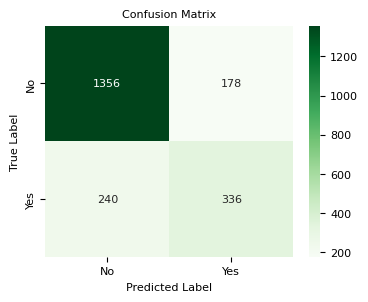

In [175]:
## Fitting interaction term only resulted in very minor imporvement in AUC

y_pred_int = glm_results_int.predict(X_test_glm)
y_pred_int_class = (y_pred_int >= 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_int_class))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_int))

plot_confusion_matrix(y_test, y_pred_int_class, labels = None)

#### Random Forest

In [176]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_encoded, y, test_size = 0.3, random_state = 44)
#X_train_rf

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1534
           1       0.64      0.51      0.57       576

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110

ROC AUC Score: 0.8246488166376937


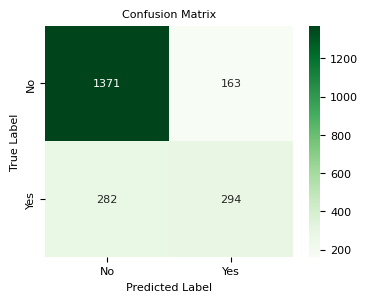

In [177]:

rf_classifier = RandomForestClassifier(random_state = 44)

rf_classifier.fit(X_train_rf, y_train_rf)

y_pred_class_rf = rf_classifier.predict(X_test_rf)
y_pred_prob_rf = rf_classifier.predict_proba(X_test_rf)[:, 1]

print("Classification Report:")
print(classification_report(y_test_rf, y_pred_class_rf))

print("ROC AUC Score:", roc_auc_score(y_test_rf, y_pred_prob_rf))

plot_confusion_matrix(y_test_rf, y_pred_class_rf, labels = None)

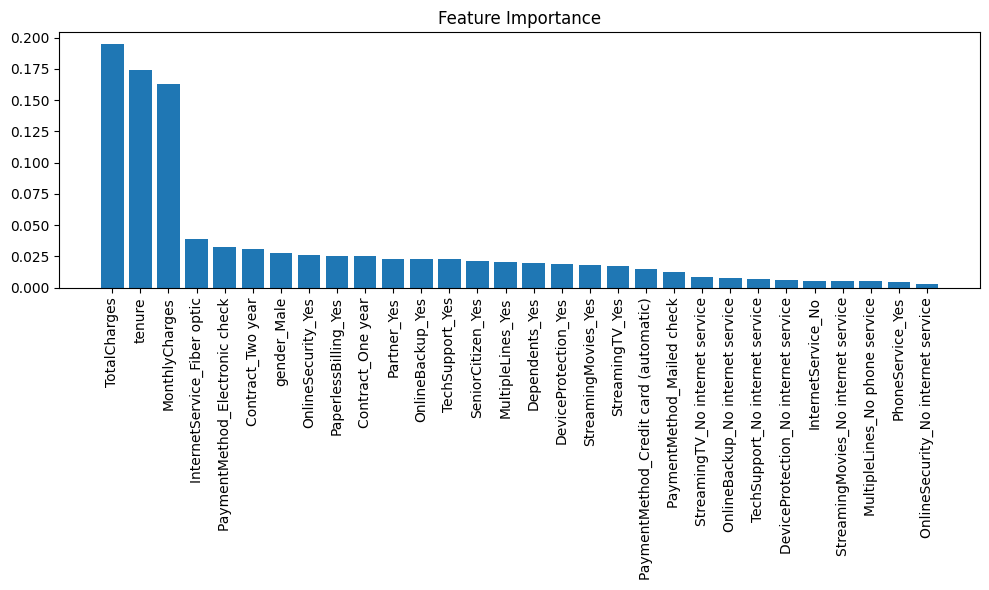

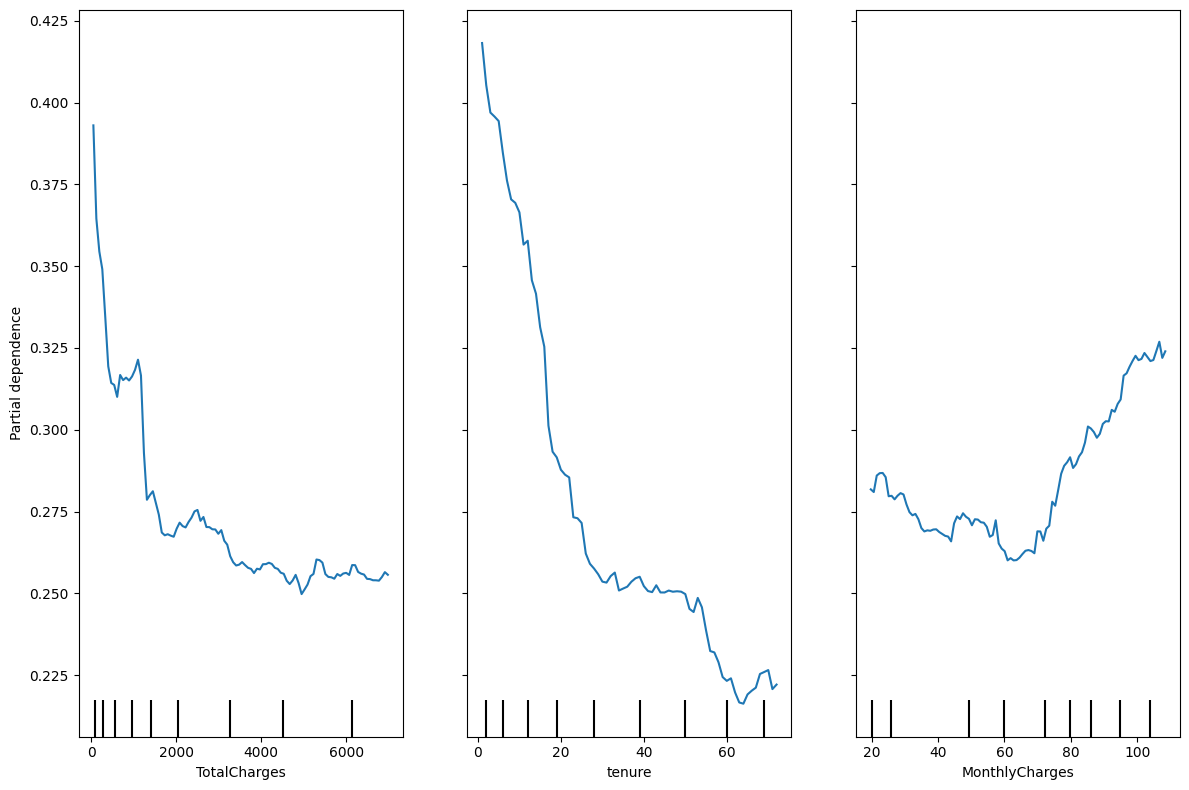

In [178]:
# Compute feature importances from the RandomForestClassifier (based on mean decrease in impurity measure)
importances = rf_classifier.feature_importances_
features = X_test_rf.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_test_rf.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test_rf.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## Generate partial dependence plots for top 3 features (which happen to be all numerical)
top_features = [features[i] for i in indices[:3]] 

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_classifier, X_test_rf, top_features, ax=ax)
plt.tight_layout()
plt.show()

#### GBM

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1534
           1       0.65      0.54      0.59       576

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.79      2110

ROC AUC Score: 0.847369350282486


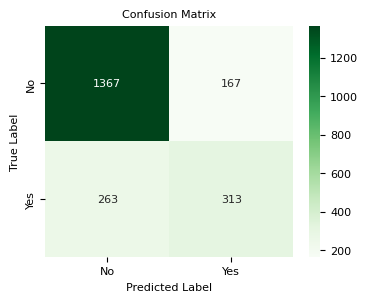

In [179]:
## Run GBM model with best parameters determined by Grid Search later on (so that Grid Search doesn't need to be run again)
## Slightly better performance than GLM and Random Forest

gbm_model = GradientBoostingClassifier(
    n_estimators = 50,  
    learning_rate = 0.15,  
    max_depth = 3,
    subsample = 0.8,       
    random_state = 44
)

gbm_model.fit(X_train_rf, y_train_rf)

y_pred_gbm_class = gbm_model.predict(X_test_rf)
y_pred_gbm_prob = gbm_model.predict_proba(X_test_rf)[:, 1]


print("Classification Report:")
print(classification_report(y_test_rf, y_pred_gbm_class))

print("ROC AUC Score:", roc_auc_score(y_test_rf, y_pred_gbm_prob))

plot_confusion_matrix(y_test_rf, y_pred_gbm_class, labels = None)

##### Grid Search

In [180]:
## Find best parameters using Grid Search over 5-fold cross validation

if False:
    
    gbm_model_xv = GradientBoostingClassifier(random_state = 44)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.05, 0.10, 0.15, 0.20],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 1.0, 1.2]
    }

    grid_search = GridSearchCV(estimator = gbm_model_xv, param_grid = param_grid, cv = 5, scoring = 'accuracy', verbose = 3)
    grid_search.fit(X_encoded, y)

    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

In [181]:
#grid_search.best_estimator_

In [182]:
if False:

    gbm_model = grid_search.best_estimator_

    gbm_model.fit(X_train_rf, y_train_rf)

    y_pred_class = gbm_model.predict(X_test_rf)
    y_pred_prob = gbm_model.predict_proba(X_test_rf)[:, 1]

    # Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_rf, y_pred_class))

    print("ROC AUC Score:", roc_auc_score(y_test_rf, y_pred_prob))

    plot_confusion_matrix(y_test_rf, y_pred_class, labels = None)

##### Adjust Precision

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.99      0.86      1534
           1       0.87      0.13      0.22       576

    accuracy                           0.76      2110
   macro avg       0.81      0.56      0.54      2110
weighted avg       0.78      0.76      0.68      2110



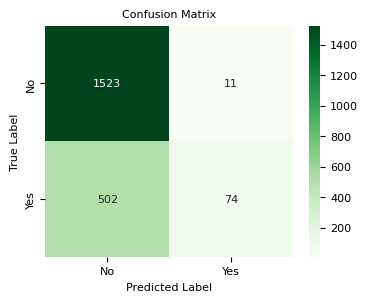

In [183]:
## Although fit was better, Precision wasn't 'pure' for using 0.8 as probability threshold compared to GLM
## That said, 0.8 was applied to a larger cohort of customers (85) compared to GLM (18)

y_pred_class_80 = (y_pred_prob >= 0.8).astype(int)
y_pred_class_80

print("Classification Report:")
print(classification_report(y_test_rf, y_pred_class_80))
plot_confusion_matrix(y_test_rf, y_pred_class_80, labels = None)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1534
           1       0.95      0.07      0.13       576

    accuracy                           0.74      2110
   macro avg       0.85      0.53      0.49      2110
weighted avg       0.80      0.74      0.65      2110



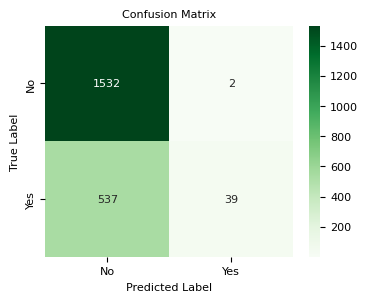

In [184]:
y_pred_class_85 = (y_pred_prob >= 0.85).astype(int)
y_pred_class_85

print("Classification Report:")
print(classification_report(y_test_rf, y_pred_class_85))
plot_confusion_matrix(y_test_rf, y_pred_class_85, labels = None)

##### Model interpretation

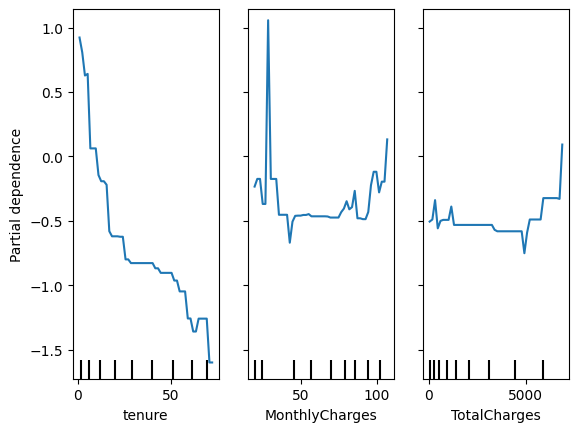

In [185]:
## PDP was slightly different for Total Charges compared to Random Forest which shows an overall decrease

numerical_features = num_col 

# Generate partial dependence plots
PartialDependenceDisplay.from_estimator(
    estimator = gbm_model, 
    X = X_train_rf,
    features = numerical_features,
    kind='average', 
    grid_resolution = 50,
    random_state = 44
)

plt.show()

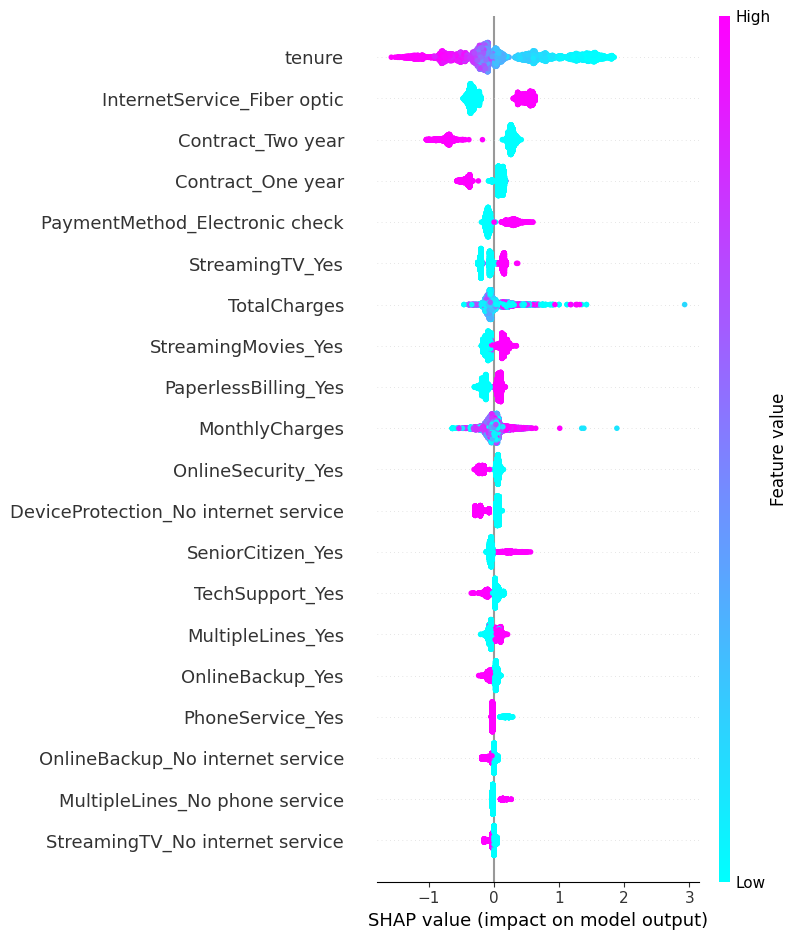

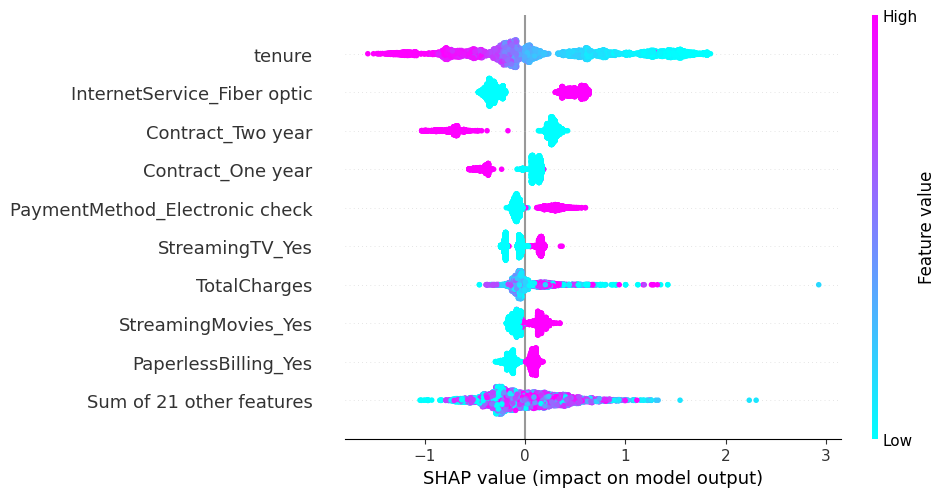

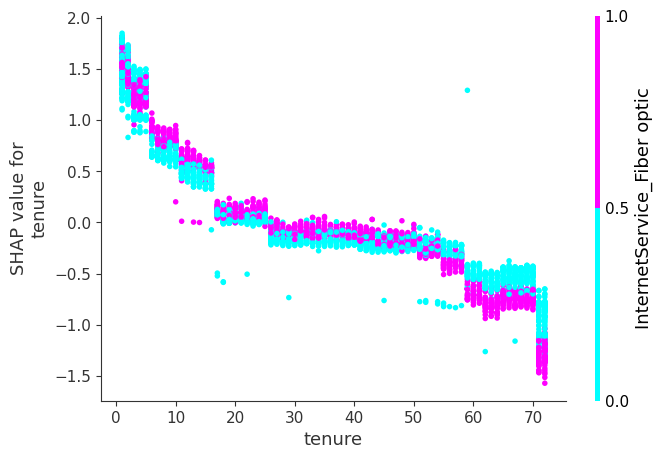

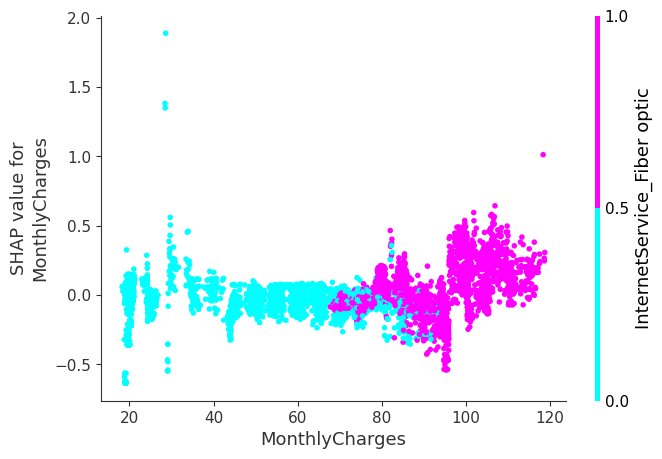

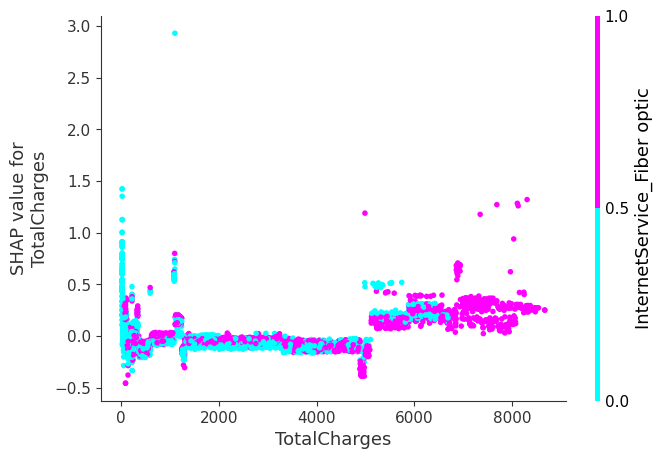

In [186]:
## Use Shapley values to explain feature importance and relativities
## Total Charges again displayed a slightly different relativity to churn (relatively flat)

explainer = shap.Explainer(grid_search.best_estimator_, X_train_rf)

# Compute SHAP values for the test set
shap_values = explainer(X_train_rf, check_additivity=False)

# 1. Plot Feature Importance (Mean Absolute SHAP Values)
shap.summary_plot(shap_values, X_train_rf, cmap = plt.get_cmap("cool"))
shap.plots.beeswarm(shap_values, color=plt.get_cmap("cool"))

# 2. Plot Dependence Plot for Numerical Features
numerical_features = num_col  # Replace with actual feature names
for feature in numerical_features:
    shap.dependence_plot(feature, shap_values.values, X_train_rf, interaction_index = 'InternetService_Fiber optic',
                         cmap = plt.get_cmap("cool"))


In [187]:
## Individual force plot

shap.initjs()

# Select an instance from the dataset (e.g., the first row of X_train)
instance_index = 0  # Change to the index of the instance you want to visualize

# Generate the force plot for the selected instance
shap.force_plot(
    explainer.expected_value,  # The base value (expected model output)
    shap_values.values[instance_index],  # SHAP values for the selected instance
    X_train_rf.iloc[instance_index]  # Feature values for the selected instance
)

- Tenure and locked-in Contract reduces this customer's likehood to churn <br>
- Monthly Charges and Fibre optic Internet Service should almost be bundled together as a factor which had immaterial impact on churn <br>
- Non-automatic Payment Method seems to increase likehood of churn. <br>

$E[f(X)]$ (-1.78) represents the sum of average effect of each feature, computed as change in response variable (in the log odd scale) by adding the feature to all possible combination ('coalitions') of data points in the dataset. <br>

Each feature for an `individual` data point is not expected to align with the mean, but deviate from it to arrive at the individual $f(X) (-2.547).

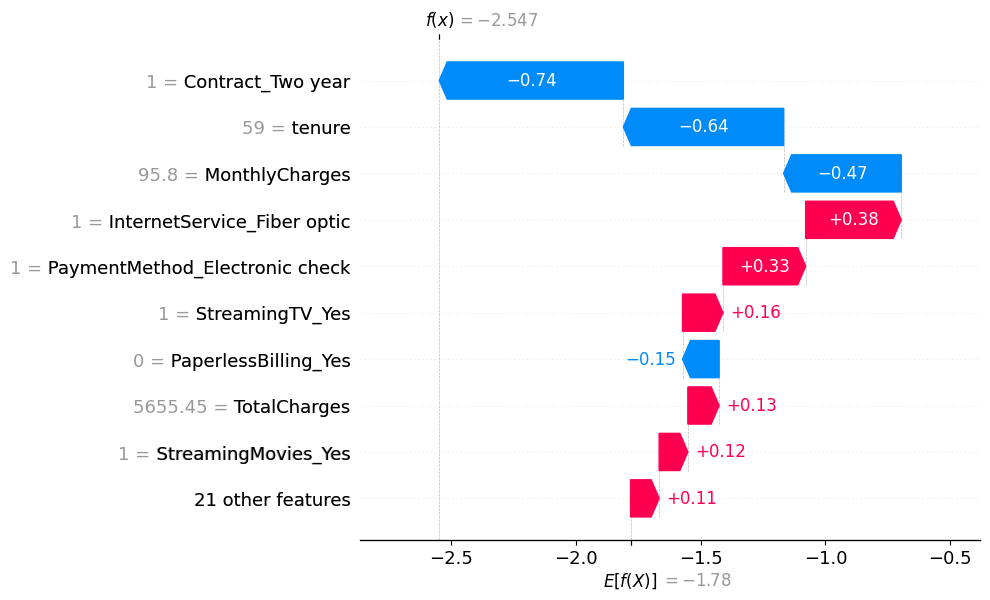

In [188]:
## Waterfall plot for an indivdual customer (identified by index number)
## Tenure and locked-in Contract reduces this customer's likehood to

from shap.plots import waterfall

instance_index = 44 
instance_shap_values = shap_values[instance_index]

waterfall(instance_shap_values)

When segregating into 3 cohorts, SHAP identifies one cohort for customer with `tenure` < 16.5 which increases the likelihood of churn, another for customers with `tenure` >= 16.5 (months?), and a 2-year locked-in contract.

/var/folders/ch/1t7jcm7n0ng98g472x2ynf7r0000gn/T/ipykernel_51418/3968671614.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc = 'lower right')


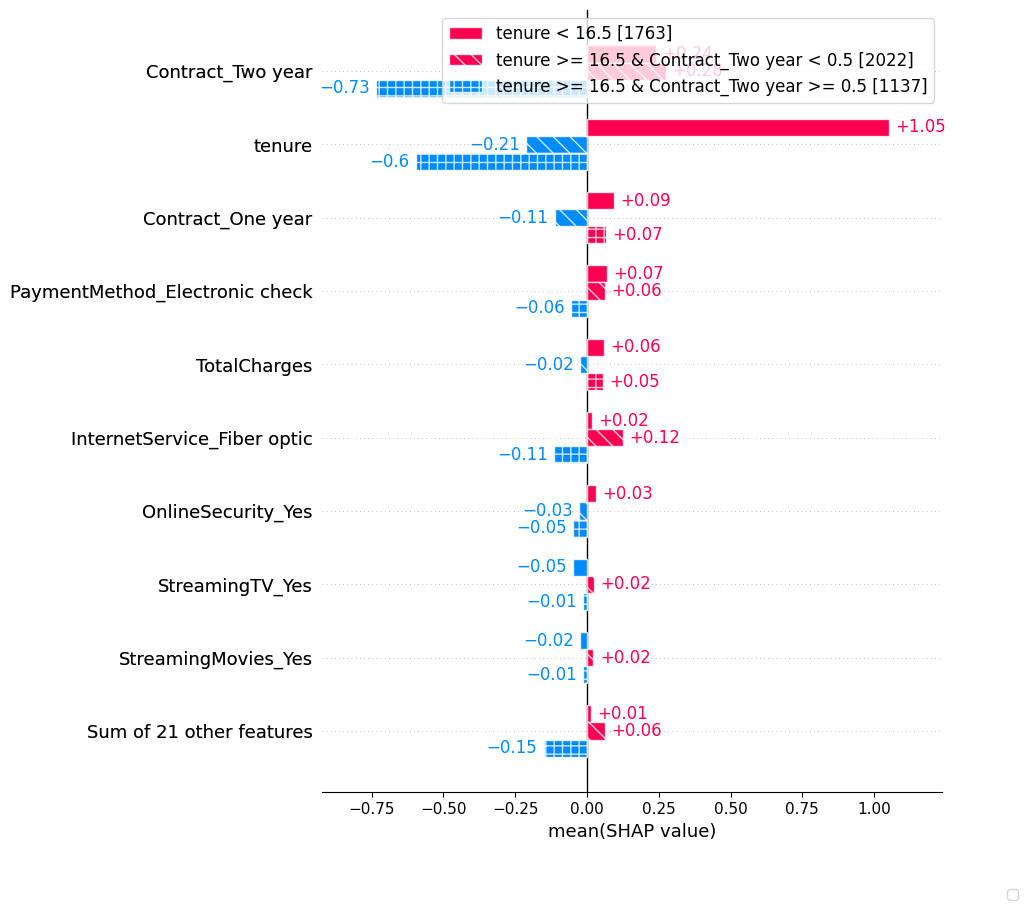

In [196]:
## Shap cohort bar plots for a pre-defined number of cohorts
## Legends overlap with chart, apparently an open issue on shap's github page...

shap.plots.bar(shap_values.cohorts(3).mean(0))
